In [2]:
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import os, os.path
import keras
import time
import scipy.misc
import scipy.ndimage

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.callbacks import CSVLogger

from PIL import Image

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K40m (CNMeM is disabled, cuDNN 5110)


In [3]:
# resolution of images

x = 75
y = 100

In [5]:
#Loading training images
#Creates list of negative files

train_n_list = glob.glob('/fhgfs/groups/e5/lhcb/detector/scifi/windingcontrol/Images_Jul_2017/Grey_800x600/NegTrain/*.bmp')
#Finds the number of negative files
train_n_len = len(train_n_list)
print("Size of negative Training Sample: {}".format(train_n_len))

#Same but for positive files
train_p_list = glob.glob('/fhgfs/groups/e5/lhcb/detector/scifi/windingcontrol/Images_Jul_2017/Grey_800x600/PosTrain/*.bmp')
train_p_len = len(train_p_list)
print("Size of positive Training Sample: {}".format(train_p_len))

#Loading test images
#Creates list of negative files
test_n_list = glob.glob('/fhgfs/groups/e5/lhcb/detector/scifi/windingcontrol/Images_Jul_2017/Grey_800x600/NegTest/*.bmp')

#Finds the number of negative files
test_n_len = len(test_n_list)
print("Size of negative Testing Sample: {}".format(test_n_len))


#Same but for positive files
test_p_list = glob.glob('/fhgfs/groups/e5/lhcb/detector/scifi/windingcontrol/Images_Jul_2017/Grey_800x600/PosTest/*.bmp')
test_p_len = len(test_p_list)
print("Size of positive Testing Sample: {}".format(test_n_len))

Size of negative Training Sample: 5118
Size of positive Training Sample: 5527
Size of negative Testing Sample: 1000
Size of positive Testing Sample: 1000


In [6]:
## Import and process image data

# Creates list of downward translated positive images 
X_train_posintd = np.array([scipy.ndimage.interpolation.shift(
    scipy.misc.imresize(np.array(Image.open(fname)),(x,y)), (20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True) 
    for fname in train_p_list])

# Creates list of downward translated negative images 
X_train_negintd = np.array([scipy.ndimage.interpolation.shift(
    scipy.misc.imresize(np.array(Image.open(fname)),(x,y)), (20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True) 
    for fname in train_n_list])

# Creates list of upward translated positive images 
X_train_posintu = np.array([scipy.ndimage.interpolation.shift(
    scipy.misc.imresize(np.array(Image.open(fname)),(x,y)), (-20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True) 
    for fname in train_p_list])

# Creates list of upward translated negative images
X_train_negintu = np.array([scipy.ndimage.interpolation.shift(
    scipy.misc.imresize(np.array(Image.open(fname)),(x,y)), (-20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True) 
    for fname in train_n_list])

## List for images without translation
X_train_pos = np.array([scipy.misc.imresize(np.array(Image.open(fname)),(x,y)) for fname in train_p_list])

X_train_neg = np.array([scipy.misc.imresize(np.array(Image.open(fname)), (x,y)) for fname in train_n_list])

In [7]:
# Same for test images

X_test_posintd = np.array([scipy.ndimage.interpolation.shift(
    scipy.misc.imresize(np.array(Image.open(fname)),(x,y)), (20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True) 
    for fname in test_p_list])

X_test_negintd = np.array([scipy.ndimage.interpolation.shift(
    scipy.misc.imresize(np.array(Image.open(fname)),(x,y)), (20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True) 
 for fname in test_n_list])

X_test_posintu = np.array([scipy.ndimage.interpolation.shift(
    scipy.misc.imresize(np.array(Image.open(fname)),(x,y)), (-20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True) 
 for fname in test_p_list])

X_test_negintu = np.array([scipy.ndimage.interpolation.shift(
    scipy.misc.imresize(np.array(Image.open(fname)),(x,y)), (-20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True) 
 for fname in test_n_list])



X_test_pos = np.array([scipy.misc.imresize(np.array(Image.open(fname)),(x,y)) for fname in test_p_list])

X_test_neg = np.array([scipy.misc.imresize(np.array(Image.open(fname)), (x,y)) for fname in test_n_list])

In [8]:
#Formating the training data into numpy arrays
X_train = np.concatenate((X_train_posintd, X_train_posintu, X_train_pos, X_train_negintd, X_train_negintu, X_train_neg), axis=0)
#Merging both positive and negative results into one numpy array
X_test = np.concatenate((X_test_posintd, X_test_posintu, X_test_pos, X_test_negintd, X_test_negintu, X_test_neg), axis=0)


#Assigning classes to images (1 for negative, 0 for positive) and changing shape of numpy array
Y_train = np_utils.to_categorical(np.concatenate((np.zeros((3*train_n_len,1)), np.ones((3*train_p_len, 1))), axis=0), 2)
#Assigning classes to images (1 for negative, 0 for positive) and changing shape of numpy array
Y_test = np_utils.to_categorical(np.concatenate((np.zeros((3*test_n_len,1)), np.ones((3*test_p_len, 1))), axis=0), 2)


#Shuffling the order of the input - required to avoid batches selecting only positive/negative images
randomize = np.arange(len(X_train))
np.random.shuffle(randomize)
X_train = X_train[randomize]
Y_train = Y_train[randomize]

randomize = np.arange(len(X_test))
np.random.shuffle(randomize)
X_test = X_test[randomize]
Y_test = Y_test[randomize]

X_train = X_train.reshape(X_train.shape[0], x, y, 1)
X_test = X_test.reshape(X_test.shape[0], x, y, 1)


#Shape check (NumberofImages, Height, Width, Depth)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(31935, 75, 100, 1)
(31935, 2)
(6000, 75, 100, 1)
(6000, 2)


In [9]:
## Class to get loss and accuracy during training of NN

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('acc'))

In [10]:
#Defining Model Architecture 
model = Sequential()

#First Convolutional layer initialised with random input weights
model.add(Conv2D(8, (13, 13), kernel_initializer='random_uniform', input_shape=(x, y, 1)))
model.add(Activation('relu')) #'relu' is an activation function which is applied to output
model.add(MaxPooling2D(pool_size=(2, 2))) #Pooling reduces the image size

#Second Convolutional layer
model.add(Conv2D(16, (11, 11)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Third Convolutional layer
model.add(Conv2D(16, (9, 9)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Converting the 2D images to 1D vectors
model.add(Flatten())  

#Fully connected layer
model.add(Dense(32))
model.add(Activation('relu'))

#Fully connected layer
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))


#Output layer
model.add(Dense(2))
model.add(Activation('softmax'))

#Defining optimiser and compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
        
history = LossHistory()
model.fit(X_train, Y_train,  batch_size=32, epochs=4, verbose=1, validation_split = 0.1, callbacks=[history])

#Evaluating trained model on test images
score = model.evaluate(X_test, Y_test, verbose=0)
print('Model has accuracy:', score[1]*100,'%')

Train on 28741 samples, validate on 3194 samples
Epoch 1/4
28741/28741 [==============================] - 63s - loss: 0.6957 - acc: 0.5217 - val_loss: 0.6940 - val_acc: 0.5038
Epoch 2/4
28741/28741 [==============================] - 63s - loss: 0.6923 - acc: 0.5209 - val_loss: 0.6942 - val_acc: 0.5038
Epoch 3/4
28741/28741 [==============================] - 63s - loss: 0.6924 - acc: 0.5209 - val_loss: 0.6940 - val_acc: 0.5038
Epoch 4/4
28741/28741 [==============================] - 63s - loss: 0.6924 - acc: 0.5209 - val_loss: 0.6934 - val_acc: 0.5038
Model has accuracy: 50.0 %


In [11]:
score

[0.69357049433390294, 0.5]

In [12]:
#To save trained NN - USE DIFFERENT NAME FOR NEW NETWORK
model.save('../TrainedModels/813_1611_169_32_32.h5')

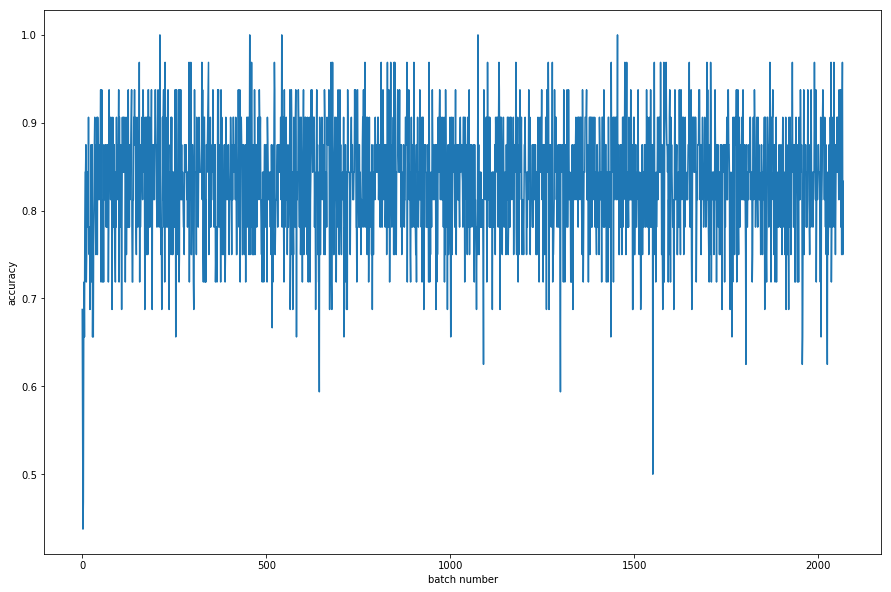

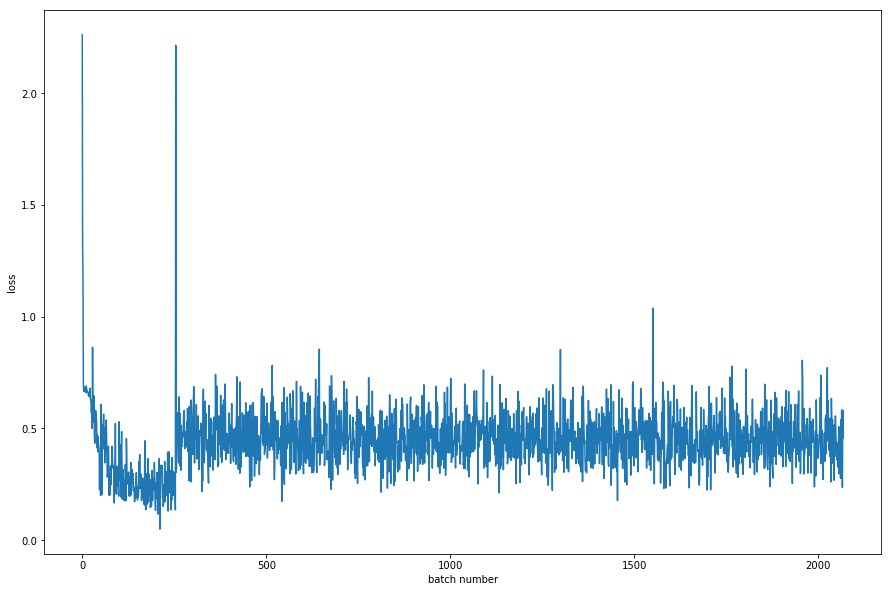

In [23]:
ACC = np.array(history.accuracy)
LOSS = np.array(history.losses)
#print(np.array(history.losses).shape)

plt.figure(figsize=(15,10))
plt.plot(ACC)
plt.ylabel('accuracy')
plt.xlabel('batch number')
plt.show()
#plt.savefig('11conv_accuracy.png')

plt.figure(figsize=(15,10))
plt.plot(LOSS)
plt.ylabel('loss')
plt.xlabel('batch number')
plt.show()
#plt.savefig('11conv_loss.png')

In [ ]:

#Defining Model Architecture 
model1 = Sequential()

#First Convolutional layer initialised with random input weights
model1.add(Conv2D(8, 13, 13, kernel_initializer='random_uniform', input_shape=(x, y, 1)))
model1.add(Activation('relu')) #'relu' is an activation function which is applied to output
model1.add(MaxPooling2D(pool_size=(2, 2))) #Pooling reduces the image size

#Second Convolutional layer
model1.add(Conv2D(16, 11, 11))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

#Second Convolutional layer
model1.add(Conv2D(16, 9, 9))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.4))


#Converting the 2D images to 1D vectors
model1.add(Flatten())  

#Fully connected layer
model1.add(Dense(32))
model1.add(Activation('relu'))

#Fully connected layer
model1.add(Dense(32))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))


#Output layer
model1.add(Dense(2))
model1.add(Activation('softmax'))

#Defining optimiser and compiling the model
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) #initial lr = 0.01 #custom optimiser
model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('acc'))
        
history = LossHistory()
model1.fit(X_train, Y_train,  batch_size=32, epochs=5, verbose=1, validation_split = 0.1, callbacks=[history])

#Evaluating trained model on test images
score = model1.evaluate(X_test, Y_test, verbose=0)
print('Model has accuracy:', score[1]*100,'%')

In [ ]:
from keras.models import load_model


model = load_model('3.h5')

In [43]:
img = np.array(Image.open('/fhgfs/groups/e5/lhcb/detector/scifi/SciFi-CAIR2/Images_Jul_2017/Grey_200x150/Positive/IMG10003.bmp'))
img = scipy.misc.imresize(img, (75,100))
img = img.reshape(1,75,100,1)
model.predict_classes(img)

1/1 [==============================] - 0s


array([0])